# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestCentroid , KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score, auc

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

import json
# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [2]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

In [3]:
def modelTestProcess(df, getdummy = 0,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    for modelname, model in modeldict.items():
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in resultdict.items():
        verboseprint(f'Classification report of {key}',':\n',value)
        verboseprint(f'F1 score of {key} is {f1scoredict[key]}\n','-'*50)
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

## **Modeling**

We will try modeling with clustering (using K-Means and Agglomerative Clustering) and compare the results with modeling without clustering.

In [4]:
dfDT = pd.read_csv('Data/dfSelect_Decision_Tree_Model.csv')
xDT, yDT = dfDT.drop('music_genre', axis=1), dfDT['music_genre']

dfKNN = pd.read_csv('Data/dfSelect_KNN_Model.csv')
xKNN, yKNN = dfKNN.drop('music_genre', axis=1), dfKNN['music_genre']

dfLR = pd.read_csv('Data/dfSelect_Logistic_Regression_Model.csv')
xLR, yLR = dfLR.drop('music_genre', axis=1), dfLR['music_genre']

dfRF = pd.read_csv('Data/dfSelect_Random_Forest_Model.csv')
xRF, yRF = dfRF.drop('music_genre', axis=1), dfRF['music_genre']

dfMLP = pd.read_csv('Data/dfSelect_MLPC_Model.csv')
xMLP, yMLP = dfMLP.drop('music_genre', axis=1), dfMLP['music_genre']

In [5]:
dfV = pd.read_csv('Data/dfOutlier_res.csv')
numCol = dfV.select_dtypes(include=np.number).columns.tolist()
cateCol = dfV.select_dtypes(exclude=np.number).columns.tolist()

### **K-Means**

In [6]:
def KMeansModelGenerator(dataFrame,k):
  df = dataFrame.copy()
  kmeans_clf = KMeans(n_clusters=k, random_state=1,)
  kmeans_clf = kmeans_clf.fit(df)
  labels = kmeans_clf.labels_
  df['Cluster'] = labels+1
  silhouetteScore = silhouette_score(df, labels, metric='euclidean', random_state=1)
  print('Silhouette score: ', silhouetteScore)
  print('WCSS: ', kmeans_clf.inertia_)
  print('Model Centroids: \n', kmeans_clf.cluster_centers_)
  for var in df['Cluster'].unique():
    print(f"Cluster ({var}) Size: {df[df['Cluster'] == var].shape[0]}")
  return kmeans_clf, df

In [7]:
def elbowVisualizer(dataFrame):
    df = dataFrame.copy()
    kmeansElbow, ax = plt.subplots(1, 1)
    visualizer = KElbowVisualizer(KMeans(random_state=1), k=(1, 11), metric='distortion', timings=False, ax=ax)
    visualizer.fit(df)
    elbow = visualizer.elbow_value_
    print('Elbow Value: ', visualizer.elbow_value_)
    print('Elbow Score: ', visualizer.elbow_score_)
    visualizer.show()
    return elbow, kmeansElbow

Elbow Value:  3
Elbow Score:  246575.84425095038


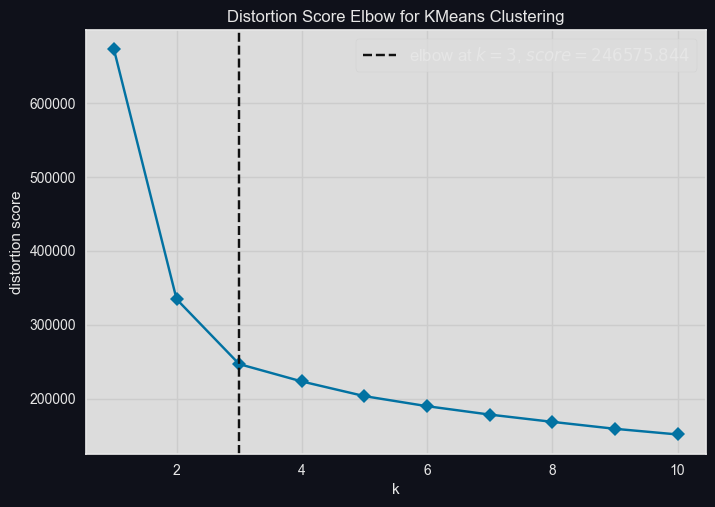

Silhouette score:  0.4271276456665667
WCSS:  246576.00996068658
Model Centroids: 
 [[-5.19208496e-01  8.38684890e-01 -4.68528526e-01  5.75814245e-01
  -6.68796766e-01  6.64509118e+00  8.37999680e-01  5.48850964e-02
  -1.87570485e-01 -3.26071009e-01]
 [ 3.51645332e-02  2.19490059e-01 -3.25953317e-02  1.12014781e-01
  -2.49420970e-03  2.07968680e-01 -8.97484399e-02  1.53422111e-01
   4.30693387e-02  1.02545051e-01]
 [ 4.18517543e-01  6.00141596e-02  4.87615866e-01 -9.14368657e-02
   9.25560417e-02  8.92081425e-02 -2.32283216e-01  4.02655654e+00
   4.91426403e-02  9.66329498e-02]]
Cluster (1) Size: 9262
Cluster (2) Size: 31410
Cluster (3) Size: 6920


In [8]:
elbowDT, kmeansDTElbow = elbowVisualizer(xDT)
ncluster_KMeansDT = elbowDT
KMeansDT_clf, dfKMeansDT = KMeansModelGenerator(xDT, ncluster_KMeansDT)

Elbow Value:  4
Elbow Score:  327544.2013818523


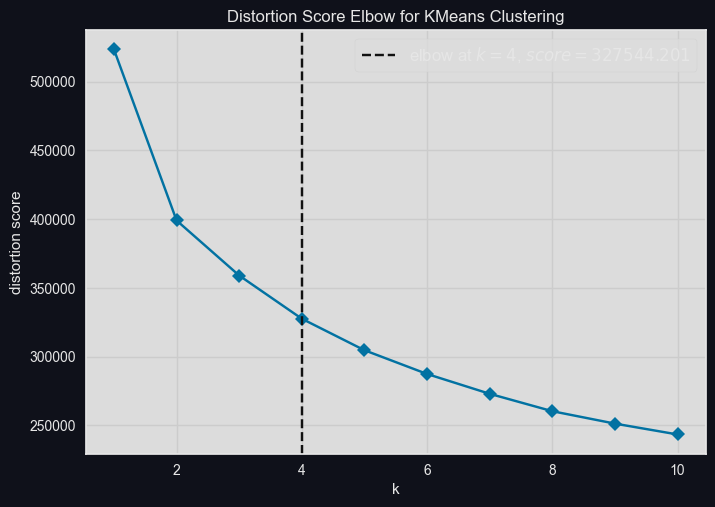

Silhouette score:  0.20198902246126277
WCSS:  327544.4036794595
Model Centroids: 
 [[ 0.75380321 -0.36540429  0.8666318  -0.27224079  0.22429013 -0.49534453
  -0.31103034  2.18763353  0.01268384  0.13249271  0.1038461 ]
 [ 0.06059368 -0.37809622  0.18243395  0.01567666  0.37066673 -0.10925254
  -0.31142912 -0.21943887  0.08395352  0.14725071  1.3520886 ]
 [ 0.06506417 -0.35146883  0.0573685  -0.0526372   0.37419592 -0.26624981
  -0.32697435 -0.34240467  0.15778076  0.24526183 -0.73959651]
 [-0.79855406  1.6387214  -1.02577731  0.30986305 -1.58022728  1.16660167
   1.44930629 -0.48452246 -0.50914738 -0.89725277 -0.06441232]]
Cluster (2) Size: 11487
Cluster (3) Size: 21156
Cluster (1) Size: 6360
Cluster (4) Size: 8589


In [9]:
elbowKNN, kmeansKNNElbow = elbowVisualizer(xKNN)
ncluster_KMeansKNN = elbowKNN
KMeansKNN_clf, dfKMeansKNN = KMeansModelGenerator(xKNN, ncluster_KMeansKNN)

Elbow Value:  3
Elbow Score:  449936.0165006577


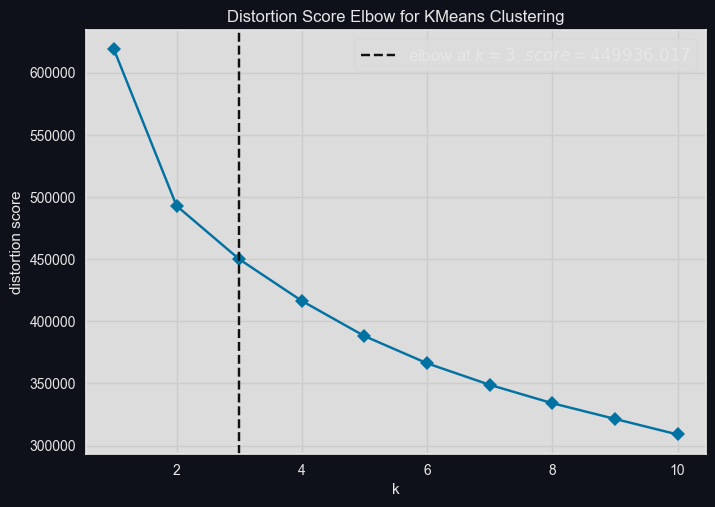

Silhouette score:  0.25026963049437245
WCSS:  449936.1723452091
Model Centroids: 
 [[ 0.26659266 -0.40775939  0.40613154 -0.1511992   0.32887146 -0.23033066
   0.04393073 -0.36262281  0.44304152  0.11345215  0.07827898  2.85954805
  -0.16809302]
 [-0.74657466  1.52277572 -0.92312224  0.30130667 -1.47409948  1.08208534
  -0.31742825  1.34880085 -0.48444873 -0.46289632 -0.82977286 -0.20082271
  -0.02152317]
 [ 0.18033512 -0.38725347  0.21205353 -0.06655192  0.38428127 -0.28367058
   0.08659061 -0.34280331  0.07844456  0.11921779  0.231574   -0.34970561
   0.03030713]]
Cluster (3) Size: 33172
Cluster (1) Size: 4736
Cluster (2) Size: 9684


In [10]:
elbowLR, kmeansLRElbow = elbowVisualizer(xLR)
ncluster_KMeansLR = elbowLR
KMeansLR_clf, dfKMeansLR = KMeansModelGenerator(xLR, ncluster_KMeansLR)


Elbow Value:  3
Elbow Score:  312745.5551197307


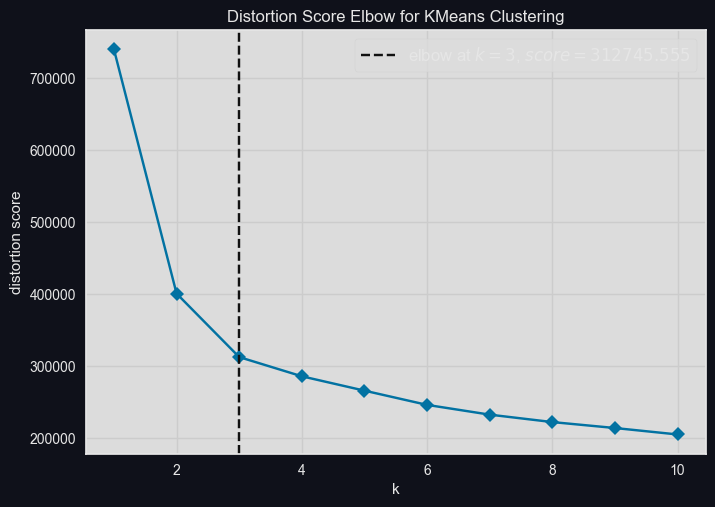

Silhouette score:  0.4105455806510139
WCSS:  312745.6018102105
Model Centroids: 
 [[ 4.16277888e-01  6.00469409e-02  4.83625542e-01 -9.20589307e-02
   9.56335094e-02  9.00888609e-02  6.51216172e-01 -2.33940771e-01
   4.00604640e+00  5.04299961e-02  9.70320893e-02  1.96100917e-01
   4.33342890e-01]
 [-5.19149354e-01  8.39920507e-01 -4.68773501e-01  5.75121119e-01
  -6.70283448e-01  6.64716010e+00  1.68356769e-01  8.39121356e-01
   5.53124742e-02 -1.87659646e-01 -3.26290396e-01  9.30307942e-02
   4.06158833e-01]
 [ 3.46536376e-02  2.19617378e-01 -3.29104614e-02  1.12921834e-01
  -3.10394356e-03  2.08867890e-01  4.60903823e-01 -8.91809770e-02
   1.49067691e-01  4.27440589e-02  1.02438724e-01  9.42890852e-02
   3.20334173e-01]]
Cluster (2) Size: 9255
Cluster (3) Size: 31368
Cluster (1) Size: 6969


In [11]:
elbowRF, kmeansRFElbow = elbowVisualizer(xRF)
ncluster_KMeansRF = elbowRF
KMeansRF_clf, dfKMeansRF = KMeansModelGenerator(xRF, ncluster_KMeansRF)

Elbow Value:  3
Elbow Score:  314128.83285195625


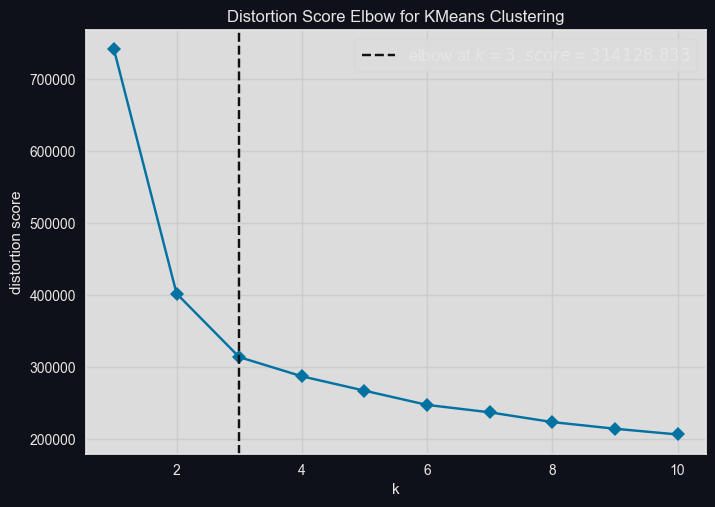

Silhouette score:  0.38090970032624377
WCSS:  314128.8729828112
Model Centroids: 
 [[-5.19149354e-01  8.39920507e-01 -4.68773501e-01  5.75121119e-01
  -6.70283448e-01  6.64716010e+00  1.68356769e-01  8.39121356e-01
   5.53124742e-02 -1.87659646e-01 -3.26290396e-01  9.30307942e-02
   3.92220421e-02  4.06158833e-01]
 [ 3.48728721e-02  2.19531980e-01 -3.28775256e-02  1.12793332e-01
  -2.97744198e-03  2.08896957e-01  4.60975706e-01 -8.92460475e-02
   1.49913809e-01  4.27552922e-02  1.02213397e-01  9.43745020e-02
   3.00557769e-02  3.20382470e-01]
 [ 4.16057298e-01  6.01109151e-02  4.84515824e-01 -9.18920238e-02
   9.52619692e-02  8.97190094e-02  6.51274925e-01 -2.33938624e-01
   4.00998934e+00  5.03948277e-02  9.80366773e-02  1.95920712e-01
   1.75237001e-02  4.33352485e-01]]
Cluster (1) Size: 9255
Cluster (2) Size: 31368
Cluster (3) Size: 6969


In [12]:
elbowMLP, kmeansMLPElbow = elbowVisualizer(xMLP)
ncluster_KMeansMLP = elbowMLP
KMeansMLP_clf, dfKMeansMLP = KMeansModelGenerator(xMLP, ncluster_KMeansMLP)

In [13]:
cluster_KMeansDT = dfKMeansDT['Cluster']
dfV_KMeansDT = dfV.copy()
dfV_KMeansDT['Cluster'] = cluster_KMeansDT
dfV_KMeansDT.groupby('Cluster').mean()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Cluster,,,,,,,,,,,
1,33.577413,0.564639,0.460085,273271.890664,0.396532,0.797534,0.147259,-15.429765,0.051638,111.548227,0.326137
2,45.769118,0.249641,0.565136,236353.205900,0.647023,0.025087,0.186314,-7.633955,0.057398,121.686838,0.491611
3,54.209538,0.168766,0.690284,220146.419605,0.682900,0.010828,0.207769,-6.582366,0.285718,121.993819,0.489175


In [14]:
cluster_KMeansKNN = dfKMeansKNN['Cluster']
dfV_KMeansKNN = dfV.copy()
dfV_KMeansKNN['Cluster'] = cluster_KMeansKNN
dfV_KMeansKNN.groupby('Cluster').mean()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Cluster,,,,,,,,,,,
1,56.173113,0.175456,0.715934,218151.826310,0.662391,0.015063,0.202209,-6.768306,0.291538,120.130227,0.491594
2,45.556890,0.171407,0.595142,242515.564435,0.700738,0.138440,0.185008,-6.895967,0.069201,122.199862,0.495216
3,45.625165,0.180593,0.573055,236702.204323,0.701567,0.088218,0.191329,-6.802310,0.057889,124.368161,0.519250
4,32.356852,0.853801,0.381382,267483.750572,0.188244,0.546891,0.139105,-18.869824,0.044768,104.863153,0.238320


In [15]:
cluster_KMeansLR = dfKMeansLR['Cluster']
dfV_KMeansLR = dfV.copy()
dfV_KMeansLR['Cluster'] = cluster_KMeansLR
dfV_KMeansLR.groupby('Cluster').mean()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Cluster,,,,,,,,,,,
1,48.710093,0.161244,0.634641,228365.452280,0.689877,0.099733,0.187969,-6.685167,0.130368,123.073260,0.478292
2,33.171727,0.814842,0.399536,266702.011738,0.215907,0.519532,0.137464,-17.956290,0.044759,106.202918,0.254826
3,47.383516,0.168340,0.600332,235561.033663,0.704306,0.082786,0.193909,-6.713292,0.096691,123.242388,0.515927


In [16]:
cluster_KMeansRF = dfKMeansRF['Cluster']
dfV_KMeansRF = dfV.copy()
dfV_KMeansRF['Cluster'] = cluster_KMeansRF
dfV_KMeansRF.groupby('Cluster').mean()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Cluster,,,,,,,,,,,
1,54.151241,0.168673,0.689738,220092.569044,0.683843,0.010885,0.211240,-6.576038,0.284872,122.029508,0.489673
2,33.578714,0.565268,0.460026,273216.705673,0.395973,0.797783,0.146543,-15.438759,0.051663,111.544305,0.326052
3,45.765780,0.249673,0.565055,236415.007258,0.646867,0.025195,0.185711,-7.636090,0.057220,121.677325,0.491492


In [17]:
cluster_KMeansMLP = dfKMeansMLP['Cluster']
dfV_KMeansMLP = dfV.copy()
dfV_KMeansMLP['Cluster'] = cluster_KMeansMLP
dfV_KMeansMLP.groupby('Cluster').mean()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
Cluster,,,,,,,,,,,
1,33.578714,0.565268,0.460026,273216.705673,0.395973,0.797783,0.146543,-15.438759,0.051663,111.544305,0.326052
2,45.765780,0.249673,0.565055,236415.007258,0.646867,0.025195,0.185711,-7.636090,0.057220,121.677325,0.491492
3,54.151241,0.168673,0.689738,220092.569044,0.683843,0.010885,0.211240,-6.576038,0.284872,122.029508,0.489673


### **Real Modeling**

In [18]:
def modelTestProcessFE(dfdict ,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    traintestdict = {}
    for modelname, model in modeldict.items():
        X = dfdict[modelname].drop(['music_genre'],axis=1)
        y = dfdict[modelname]['music_genre']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        traintestdict[modelname] = [X_train, X_test, y_train, y_test]
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
        verboseprint(f'-'*50)
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        X_train, X_test, y_train, y_test = traintestdict[modelname]
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

In [19]:
dfKMeansDT = pd.concat([dfKMeansDT, yDT], axis=1)
dfKMeansKNN = pd.concat([dfKMeansKNN, yKNN], axis=1)
dfKMeansLR = pd.concat([dfKMeansLR, yLR], axis=1)
dfKMeansRF = pd.concat([dfKMeansRF, yRF], axis=1)
dfKMeansMLP = pd.concat([dfKMeansMLP, yMLP], axis=1)

In [20]:
dfKMeansDict = {'Logistic Regression Model':dfKMeansLR,
                'Decision Tree Model':dfKMeansDT,
                'Random Forest Model':dfKMeansRF,
                'KNN Model':dfKMeansKNN,
                'MLPC Model':dfKMeansMLP}

### **Hyperparameter Tuning**

In [29]:
def MLPTuning(data, number):
    f1sc = make_scorer(f1_score, average='weighted')
    MLP_param2, dfMLP, yMLP = data

    if os.path.exists('Data/paramTuning/tunedMLP.json'):
        with open('Data/paramTuning/tuned.json', 'r') as f:
            tuned = json.load(f)
    else:
        os.makedirs('Data/paramTuning')
        tuned = {}
        with open('Data/paramTuning/tunedMLP.json', 'w') as f:
            json.dump(tuned, f)

    MLP_clf = MLPClassifier(random_state=1,)
    grid = GridSearchCV(MLP_clf, param_grid=MLP_param2, cv=4, scoring=f1sc, n_jobs=-1)

    X_train, _, y_train, _ = train_test_split(dfMLP, yMLP, test_size=0.2, random_state=1)
    grid.fit(X_train, y_train)

    tuned[f'MLPClassifier{number}'] = grid.best_params_
    with open('Data/paramTuning/tunedMLP.json', 'w') as f:
        json.dump(tuned, f)

    return tuned

In [31]:
MLP_param1 = [{
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.001, 0.01, 0.1, 1],
}]

MLP_param2 = [{
    'hidden_layer_sizes': [(50,),(100,),(150,),(200,),(250,),(300,),(350,),(400,),(450,),(500,),(550,),(600,),(650,),(700,),(750,),(800,),(850,),(900,),(950,),(1000,),
                           (50,50),(50,50,50),(50,50,50,50),(50,50,50,50,50),(50,50,50,50,50,50),(50,50,50,50,50,50,50),(50,50,50,50,50,50,50,50),(50,50,50,50,50,50,50,50,50),
                           (100,100),(100,100,100),(100,100,100,100),(100,100,100,100,100),(100,100,100,100,100,100),(100,100,100,100,100,100,100),(100,100,100,100,100,100,100,100),(100,100,100,100,100,100,100,100,100),
                           (14,14),(14,14,14),(14,14,14,14),(14,14,14,14,14),(14,14,14,14,14,14),(14,14,14,14,14,14,14),(14,14,14,14,14,14,14,14),(14,14,14,14,14,14,14,14,14),
                           (28,28),(28,28,28),(28,28,28,28),(28,28,28,28,28),(28,28,28,28,28,28),(28,28,28,28,28,28,28),(28,28,28,28,28,28,28,28),(28,28,28,28,28,28,28,28,28),
                           (100,),(100,100,),(50,50,),(50,50,25),(100,100,100,), (100,100,100,100,),(7,),(7,100),(7,100,100),(7,100,100,100),
                           (7,50,50,50),(7,50,50,50,50),(7,50,50,50,50,50),(7,50,50,50,50,50,50),(7,50,50,50,50,50,50,50),(7,50,50,50,50,50,50,50,50),],
}]

MLPGrid1 = MLP_param1, xMLP, yMLP
MLPGrid2 = MLP_param2, xMLP, yMLP

In [23]:
MLPTunedParams1 = MLPTuning(MLPGrid1,1)

In [32]:
MLPTunedParams2 = MLPTuning(MLPGrid2,2)